In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Bernoulli = tf.contrib.distributions.Bernoulli
st = tf.contrib.bayesflow.stochastic_tensor

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
batch_size = 40
ns = 1
lr = 1e-3
eps = 1e-7
alpha = 0.9
PD = False

def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
            b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    if af is None:
        return tf.matmul(inputs, w) + b
    return af(tf.matmul(inputs, w) + b)

def get_weights(wn, bn, in_dim, out_dim):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    return [w,b]

def sample(p):
    return st.StochasticTensor(dist=Bernoulli(probs=p, dtype=tf.float32),
                               dist_value_type=st.SampleValue()).value()
def prob(p, s):
    return s*p + (1.0-s)*(1.0-p)

x = tf.placeholder(tf.float32, [None, 392])
yy = tf.placeholder(tf.float32, [None, 392])
y_ = tf.tile(yy, [ns, 1])

h = tf.tile(add_layer(x, "wxh", "bxh", 392, 200, tf.nn.sigmoid), [ns, 1])
if PD is False:
    sh = tf.stop_gradient(sample(h))
else:
    sh = tf.stop_gradient(sample(h)-h)+h
y = add_layer(sh, "why", "bhy", 200, 392, tf.nn.sigmoid)
y = prob(y, y_)
y_expect = tf.reduce_mean(tf.reshape(y, [ns, batch_size, 392]), 0)
nll = tf.reduce_mean(tf.reduce_sum(-tf.log(tf.clip_by_value(y_expect, eps, 1.0-eps)), 1))
loss = tf.reduce_sum(-tf.log(tf.clip_by_value(y, eps, 1.0-eps)), 1, keep_dims=True)

saver = tf.train.Saver()

In [9]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)
p = tf.log(tf.clip_by_value(prob(h, sh), eps, 1.0-eps))


def gd_est(md, linear=True):
    func = {
        0: LR,
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL
    }
    f, g, mg, tr, m, v = func.get(md)()
    df = opt.compute_gradients(nll+tf.reduce_mean(f, 0), [get_weights("wxh", "bxh", 392, 200),
                                                          get_weights("why", "bhy", 200, 392)])
    if g is None:
        dg = tf.zeros([2,1])
    else:
        dg = opt.compute_gradients(tf.reduce_mean(g, 0), [get_weights("wxh", "bxh", 392, 200)])
    if mg is None:
        dmg = tf.zeros([2,1])
    else:
        dmg = opt.compute_gradients(tf.reduce_mean(mg, 0), [get_weights("wxh", "bxh", 392, 200)])

    est = [list(df[0]), list(df[1]), list(df[2]), list(df[3])]
    if linear is True:
        est[0][0] -= dg[0][0] - dmg[0][0]
        est[1][0] -= dg[1][0] - dmg[1][0]
    else:
        est[0][0] *= dmg[0][0] / (dg[0][0]+eps)
        est[1][0] *= dmg[1][0] / (dg[1][0]+eps)
    if tr is not None:
        est += list(tr)
    est[0][0] = tf.check_numerics(est[0][0],'dwxh')
    est[1][0] = tf.check_numerics(est[1][0],'dbxh')
    est[2][0] = tf.check_numerics(est[2][0],'dwhy')
    est[3][0] = tf.check_numerics(est[3][0],'dbhy')    
    train_step = opt.apply_gradients(est)
    return train_step, nll, m, v

def LR():
    f = tf.stop_gradient(loss) * p
    return f, None, None, None, tf.constant(0.), tf.constant(0.)

def muProp():
    ch = tf.clip_by_value(add_layer(h, "why", "bhy", 200, 392, tf.nn.sigmoid), eps, 1.0-eps)
    loss_ch = tf.reduce_sum(-tf.log(prob(ch, y_)), 1, keep_dims=True)
    dh = tf.gradients(loss_ch, h)[0]
    g = tf.stop_gradient(loss_ch+tf.reduce_sum(dh*(sh-h),1,keep_dims=True)) * p
    mg = tf.stop_gradient(dh) * h
    f = tf.stop_gradient(loss) * p
    return f, g, mg, None, tf.constant(0.), tf.constant(0.)
        
def DARN():
    dh = tf.gradients(loss, sh)[0]
    g = tf.stop_gradient(loss + dh*(0.5-sh)) * p
    f = tf.stop_gradient(loss) * p
    return f, g, None, None, tf.constant(0.), tf.constant(0.)

def baseline():
    b = alpha*bsln + (1.0-alpha)*tf.reduce_mean(loss)
    g = tf.stop_gradient(b) * p
    f = tf.stop_gradient(loss) * p
    return f, g, None, None, b, tf.constant(0.)

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-cy-tf.reduce_mean(loss-cy)))/tf.maximum(1.0, (ns-1))
    v = alpha*bslnv + (1.0-alpha)*vv
    g = tf.stop_gradient((cy+b)/tf.maximum(1.0,tf.sqrt(v))) * p
    f = tf.stop_gradient(loss/tf.maximum(1.0,tf.sqrt(v))) * p
    tr = opt.compute_gradients(tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), [get_weights("wh", "bh", 392, 100),
                                                                                        get_weights("wy", "by", 100, 1)])
    return f, g, None, tr, b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, nll, tf.constant(0.), tf.constant(0.)



In [11]:
def train(train_op):
    with tf.Session() as sess:
        bl = 0.
        vr = 0.
        ll = []
        t = 0.
        sess.run(tf.global_variables_initializer())

        for i in range(50000):
            batch_ = data.next_batch(batch_size)[0]
            batch_xs = batch_[:,0:392]
            batch_ys = batch_[:,392:784]

            res = sess.run(train_op, {x: batch_xs, yy: batch_ys, bsln: bl, bslnv: vr})
            bl = res[-2]
            vr = res[-1]
            
            t += res[-3]
            if (i+1)%1000==0:
                t /= 1000
                ll.append(t)
                print i/1000, t,
                t = 0. 
                
       # save_path = saver.save(sess, "model/model.ckpt")
    return ll

In [14]:
#train_op = ST_()
train_op = gd_est(0)
lhr = train(train_op)

0 350.20065889 1 205.656286621 2 168.121567276 3 143.484906845 4 125.45751487 5 113.040306946 6 104.043709 7 97.9117740936 8 93.5851361771 9 90.6602395401 10 88.7328150635 11 87.3820297241 12 86.4710669861 13 85.5889910889 14 84.8494092102 15 84.1889582367 16 83.7698368759 17 83.5273413696 18 83.4326505966 19 83.0299238815 20 82.8260694351 21 82.612630806 22 82.5628891449 23 82.5549526291 24 82.4742217026 25 82.3493715668 26 82.1489689407 27 81.9680053101 28 81.9077572861 29 81.760968277 30 81.6486933746 31 81.5763012543 32 81.5168711929 33 81.3623471603 34 81.2651650467 35 81.1859680557 36 81.0554558411 37 80.9608473244 38 80.8874503937 39 80.7870106049 40 80.7534956894 41 80.8107467957 42 80.6647249374 43 80.6448443604 44 80.4836687927 45 80.4497227783 46 80.4427318192 47 80.3570456924 48 80.2366486588 49 80.2252908325


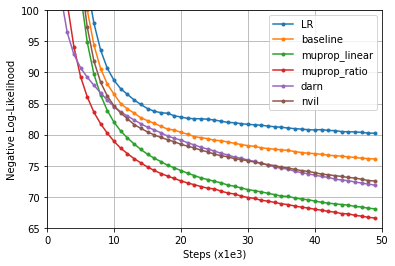

In [19]:
fig = plt.figure()
ax = plt.subplot(111)
plt.xlim(0, 50)
plt.ylim(65, 100)

ax.plot(lhr, '.-',label="LR")
ax.plot(bl, '.-',label="baseline")
ax.plot(mp, '.-', label="muprop_linear")
ax.plot(mpr, '.-', label="muprop_ratio")
ax.plot(dn, '.-', label="darn")
ax.plot(nv, '.-', label="nvil")

plt.legend()
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
plt.grid()
plt.show()
#fig.savefig('foo.png')